In [ ]:
# Install required libraries
!pip install scikit-learn matplotlib seaborn xgboost catboost lightgbm shap --quiet
!pip install tensorflow --upgrade --quiet
!pip install geopandas folium --quiet  # For spatial analysis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.


In [ ]:
!pip install nltk

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import joblib


In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Load the dataset
df = pd.read_csv("/content/crop_suitability_multi_label_5 _class.csv")

In [ ]:
# Data cleaning
print("Missing values before cleaning:")
print(df.isnull().sum())


Missing values before cleaning:
Sample_ID            0
State                0
Season               0
Year                 0
NDVI                 0
Seasonal_Rainfall    0
Annual_Rainfall      0
Temperature          0
pH_0_5               0
Carbon               0
Texture              0
Paddy                0
Wheat                0
Apple                0
Tea                  0
Coconut              0
dtype: int64


In [ ]:
# Convert boolean crop columns to integers (0/1)
crop_columns = df.select_dtypes(include='bool').columns
df[crop_columns] = df[crop_columns].astype(int)

In [ ]:
# Encode categorical columns
df['State'] = LabelEncoder().fit_transform(df['State'])
df['Season'] = LabelEncoder().fit_transform(df['Season'])

In [ ]:
# Feature engineering
# Since we don't have lat/long, we'll create region-based features from State
# Create region aggregates (assuming State represents geographic regions)
state_rainfall_avg = df.groupby('State')['Annual_Rainfall'].mean().to_dict()
state_temp_avg = df.groupby('State')['Temperature'].mean().to_dict()

df['State_Rainfall_Deviation'] = df.apply(lambda x: x['Annual_Rainfall'] - state_rainfall_avg[x['State']], axis=1)
df['State_Temp_Deviation'] = df.apply(lambda x: x['Temperature'] - state_temp_avg[x['State']], axis=1)

In [ ]:
# Add interaction features
df['Rainfall_Temp_Interaction'] = df['Annual_Rainfall'] * df['Temperature']
df['NDVI_pH_Interaction'] = df['NDVI'] * df['pH_0_5']

In [ ]:
# Select relevant features
features = ['NDVI', 'Annual_Rainfall', 'Temperature', 'pH_0_5', 'Carbon',
            'State', 'Season', 'State_Rainfall_Deviation', 'State_Temp_Deviation',
            'Rainfall_Temp_Interaction', 'NDVI_pH_Interaction']

# Select target crops (5 as specified)
selected_crops = ['Paddy', 'Wheat', 'Apple', 'Tea', 'Coconut']
y = df[selected_crops]

In [ ]:
# Normalize/scale continuous features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Save the scaler for later use
joblib.dump(scaler, 'feature_scaler.pkl')


['feature_scaler.pkl']

In [ ]:
# Already converted to one-hot (0/1) format
print("\nLabel distribution:")
print(y.sum())


Label distribution:
Paddy      5810
Wheat      2174
Apple       544
Tea        3177
Coconut    9474
dtype: int64


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
""" 3.1 Deep Learning Model"""

# Calculate class weights for imbalanced data
n_samples = len(df)
positive_counts = y.sum()

class_weights = {
    i: n_samples / (len(selected_crops) * count)
    for i, count in enumerate(positive_counts)
}

# Custom weighted loss function
def get_weighted_loss(class_weights):
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # avoid log(0)
        loss = 0
        for i in range(len(class_weights)):
            weight = class_weights[i]
            loss += -weight * (y_true[:, i] * tf.math.log(y_pred[:, i]) +
                               (1 - y_true[:, i]) * tf.math.log(1 - y_pred[:, i]))
        return tf.reduce_mean(loss)
    return weighted_binary_crossentropy

# Build DL model
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(y.shape[1], activation='sigmoid')  # multi-label
])

model.compile(
    optimizer='adam',
    loss=get_weighted_loss(class_weights),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train DL model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Save DL model
model.save('crop_suitability_dl_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.2673 - auc: 0.7491 - loss: 7.7871 - precision: 0.3427 - recall: 0.7413 - val_accuracy: 0.1885 - val_auc: 0.9530 - val_loss: 2.5206 - val_precision: 0.6442 - val_recall: 0.8486 - learning_rate: 0.0010
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2902 - auc: 0.9513 - loss: 2.1695 - precision: 0.7345 - recall: 0.7891 - val_accuracy: 0.2983 - val_auc: 0.9850 - val_loss: 1.0847 - val_precision: 0.8298 - val_recall: 0.8958 - learning_rate: 0.0010
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3082 - auc: 0.9710 - loss: 1.3167 - precision: 0.8158 - recall: 0.7944 - val_accuracy: 0.3257 - val_auc: 0.9902 - val_loss: 0.8021 - val_precision: 0.8569 - val_recall: 0.9177 - learning_rate: 0.0010
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3181 - auc: 0.9768 - loss: 1.1037 - precision: 0.8333 - recall: 0.8256 - val_accuracy: 0.3297 - val_auc: 0.9924 - val_loss: 0.69

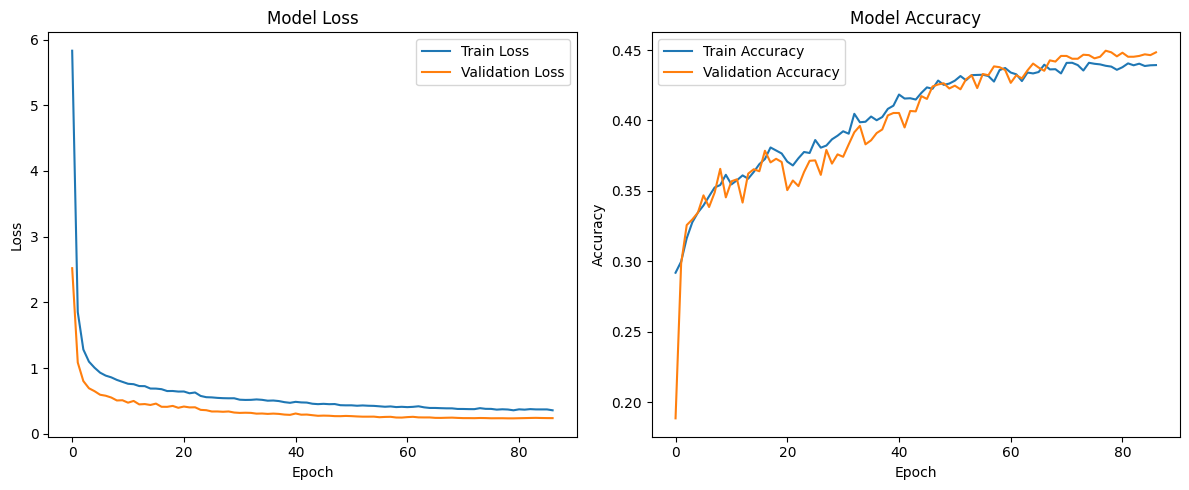

In [ ]:
# Plot training history for DL model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


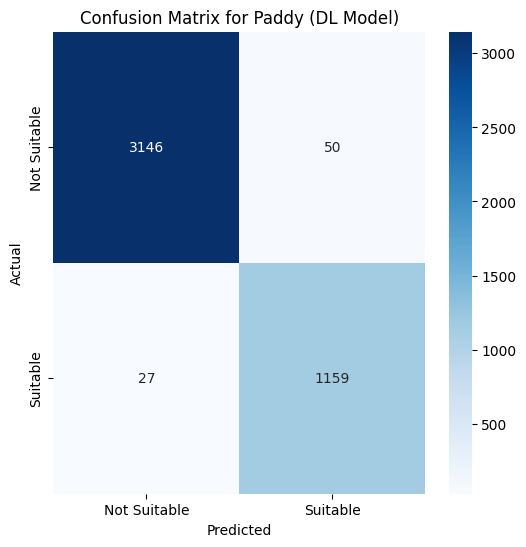

In [ ]:
# Confusion matrix for DL model (example for first crop)
plt.figure(figsize=(6, 6))

# Make predictions using the DL model
dl_preds_proba = model.predict(X_test)
dl_preds = (dl_preds_proba > 0.5).astype(int) # Threshold probabilities to get class predictions

cm = confusion_matrix(y_test.iloc[:, 0], dl_preds[:, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Suitable', 'Suitable'],
            yticklabels=['Not Suitable', 'Suitable'])
plt.title(f'Confusion Matrix for {selected_crops[0]} (DL Model)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
"""### 3.2 Random Forest Baseline"""

# Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
multi_rf = MultiOutputClassifier(rf)

multi_rf.fit(X_train, y_train)
y_pred_rf = multi_rf.predict(X_test)

# Save RF model
joblib.dump(multi_rf, 'crop_suitability_rf_model.pkl')

# --- STEP 5: Predict ---
y_pred = multi_rf.predict(X_test)

# --- STEP 6: Evaluate ---
print(classification_report(y_test, y_pred, target_names=crop_columns))

              precision    recall  f1-score   support

       Paddy       1.00      1.00      1.00      1186
       Wheat       1.00      1.00      1.00       419
       Apple       1.00      1.00      1.00       107
         Tea       1.00      1.00      1.00       626
     Coconut       1.00      1.00      1.00      1960

   micro avg       1.00      1.00      1.00      4298
   macro avg       1.00      1.00      1.00      4298
weighted avg       1.00      1.00      1.00      4298
 samples avg       0.57      0.57      0.57      4298



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


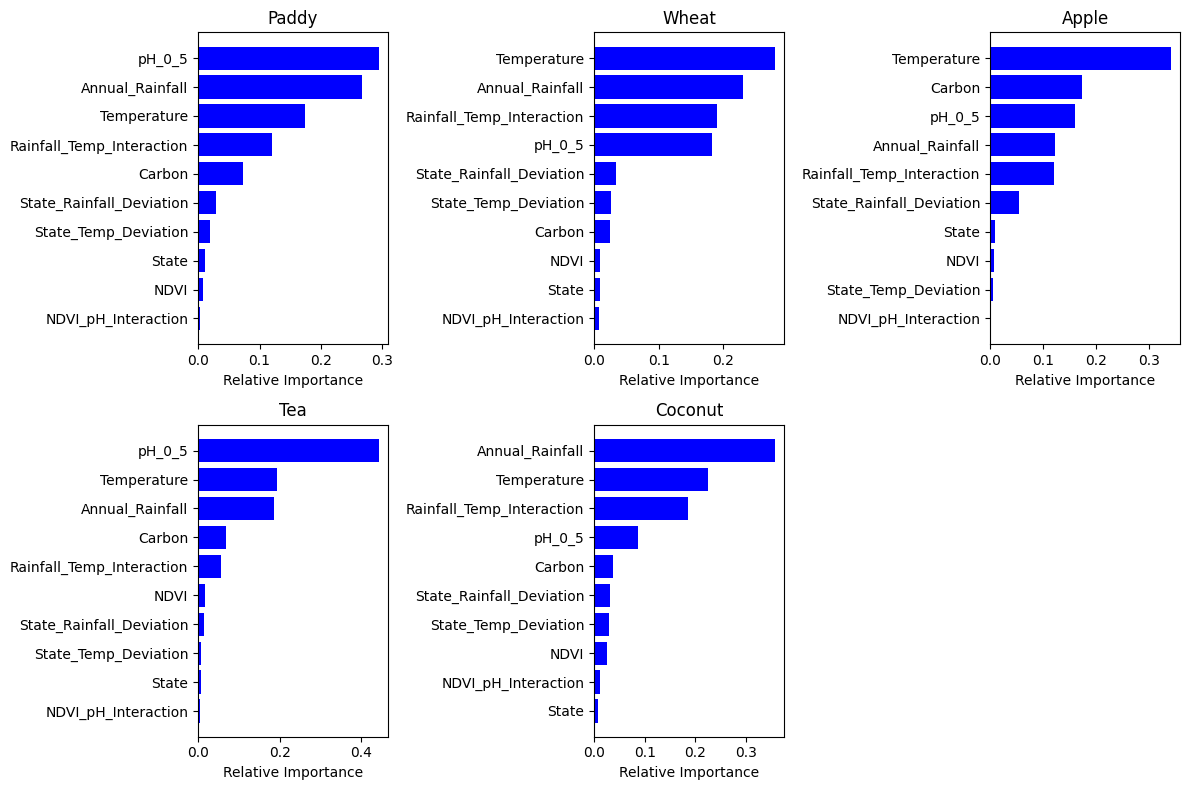

In [ ]:
# Get feature importance for each crop
plt.figure(figsize=(12, 8))
for i, crop in enumerate(selected_crops):
    plt.subplot(2, 3, i+1)
    importances = multi_rf.estimators_[i].feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10 features
    plt.title(crop)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

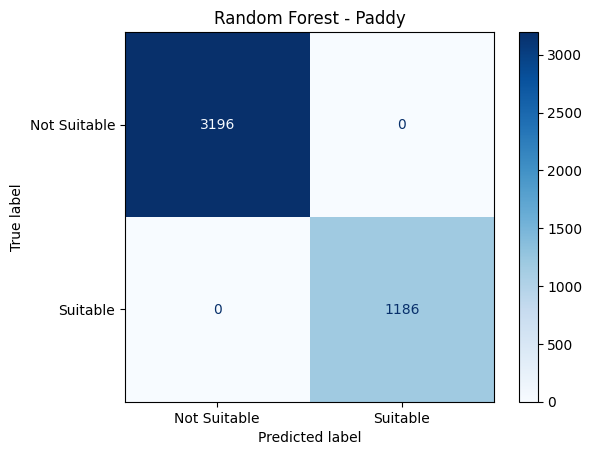

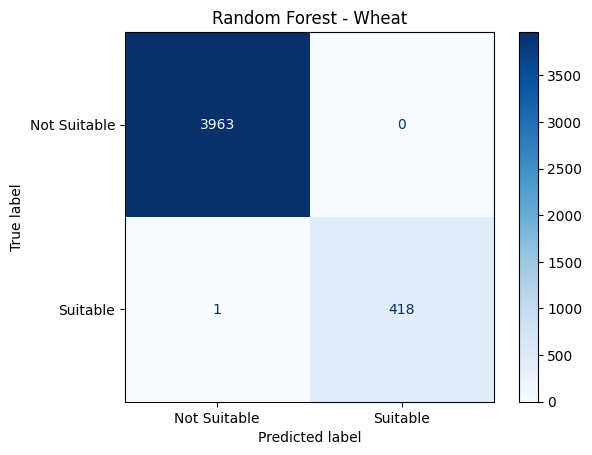

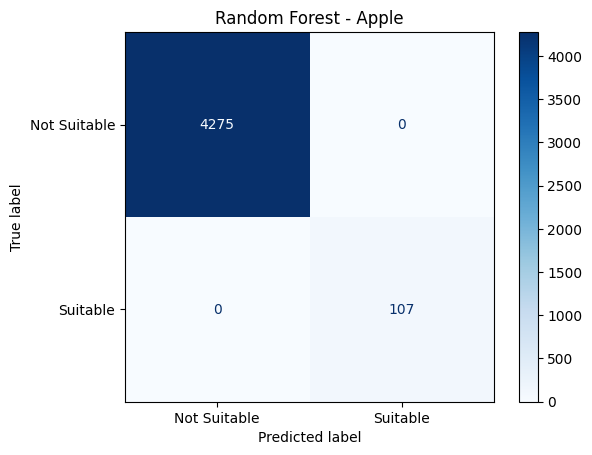

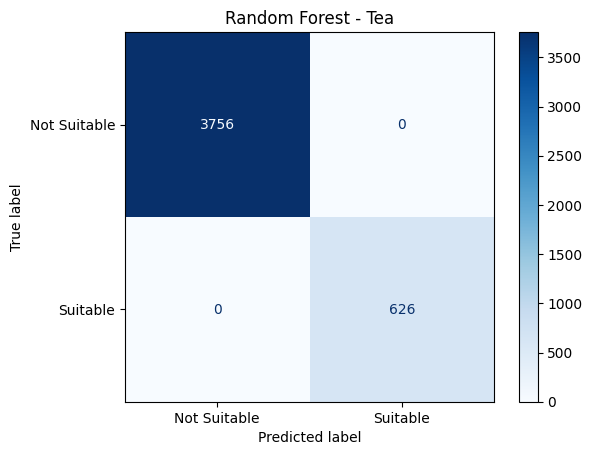

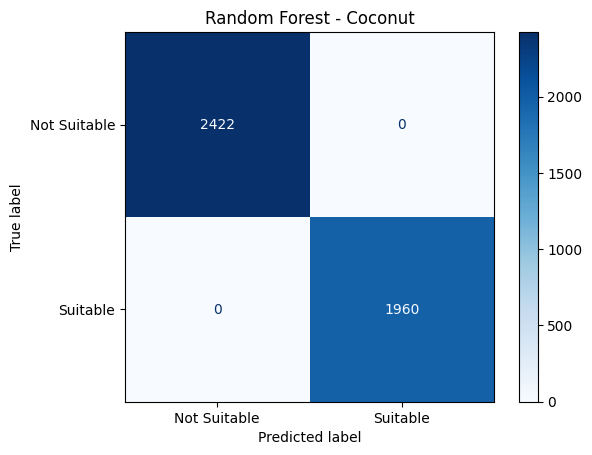

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

for i, crop in enumerate(selected_crops):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred_rf[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=['Not Suitable', 'Suitable'])
    disp.plot(cmap='Blues')
    plt.title(f'Random Forest - {crop}')
    plt.show()

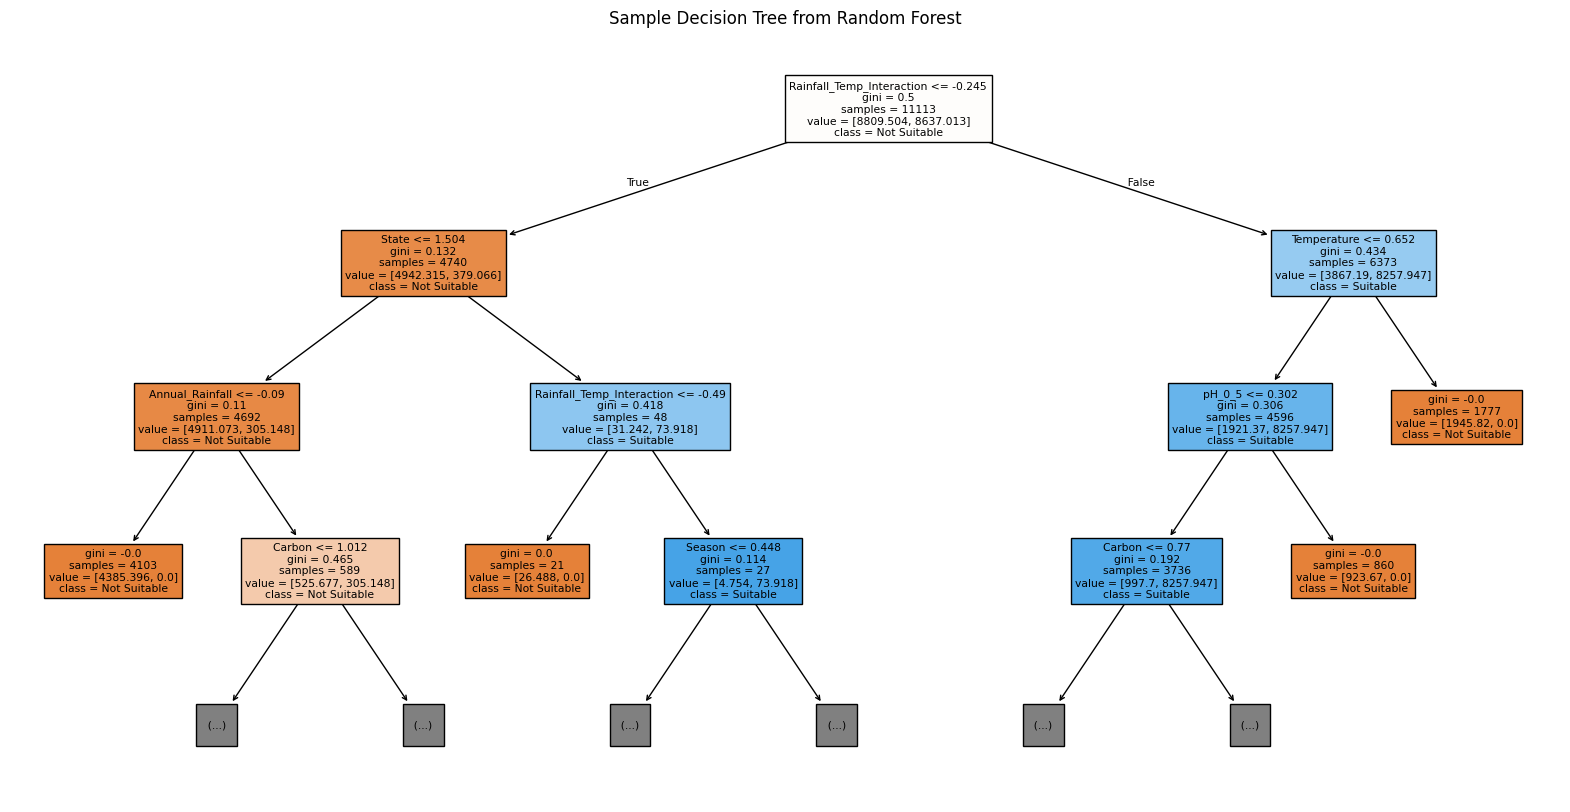

In [ ]:
from sklearn.tree import plot_tree

# Visualize one tree from the first crop's forest
plt.figure(figsize=(20, 10))
plot_tree(multi_rf.estimators_[0].estimators_[0],
         feature_names=features,
         class_names=['Not Suitable', 'Suitable'],
         filled=True, max_depth=3)
plt.title('Sample Decision Tree from Random Forest')
plt.show()

In [ ]:
# XGBoost model with hyperparameter tuning
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    is_unbalance=True
)

multi_xgb = MultiOutputClassifier(xgb_base)

params = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 5, 7],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__subsample': [0.6, 0.8, 1.0],
    'estimator__colsample_bytree': [0.6, 0.8, 1.0]
}

grid = RandomizedSearchCV(multi_xgb, param_distributions=params, cv=3, n_iter=10, verbose=1)
grid.fit(X_train, y_train)

best_xgb = grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:45:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:45:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:45:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:45:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:45:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "is_unbalance" } are not used.



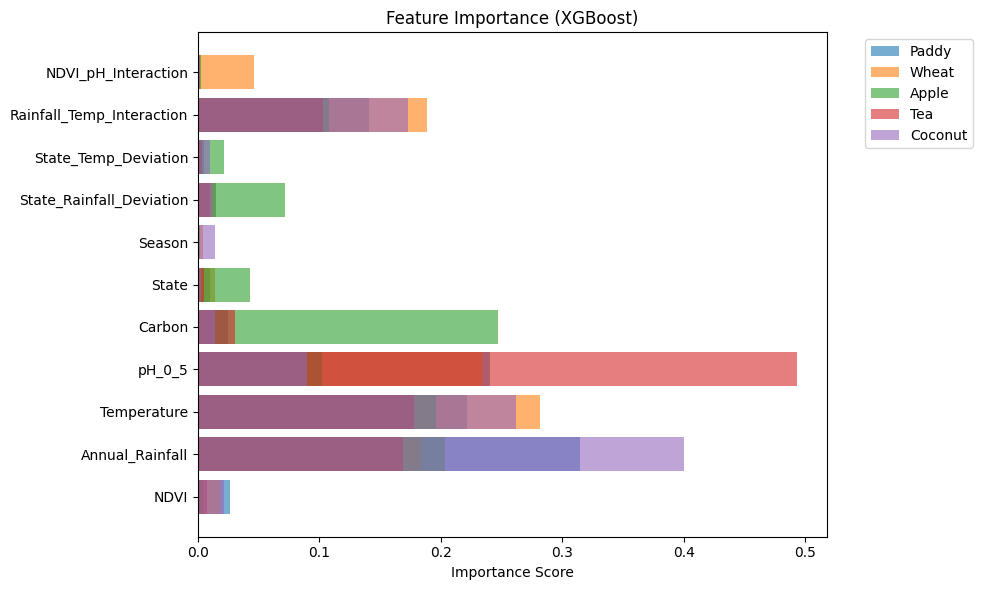

In [ ]:
# Feature importance for XGBoost
plt.figure(figsize=(10, 6))
for i, crop in enumerate(selected_crops):
    xgb_importance = best_xgb.estimators_[i].feature_importances_
    plt.barh(features, xgb_importance, alpha=0.6, label=crop)
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# --- STEP 5: Predict ---
# Use the best_xgb model obtained from the RandomizedSearchCV
y_pred = best_xgb.predict(X_test)

# --- STEP 6: Evaluate ---
print(classification_report(y_test, y_pred, target_names=crop_columns))

# Print the best parameters found by the grid search
print("Best parameters found by Randomized Search:")
print(grid.best_params_)

              precision    recall  f1-score   support

       Paddy       1.00      1.00      1.00      1186
       Wheat       1.00      1.00      1.00       419
       Apple       0.99      1.00      1.00       107
         Tea       1.00      1.00      1.00       626
     Coconut       1.00      1.00      1.00      1960

   micro avg       1.00      1.00      1.00      4298
   macro avg       1.00      1.00      1.00      4298
weighted avg       1.00      1.00      1.00      4298
 samples avg       0.57      0.57      0.57      4298

Best parameters found by Randomized Search:
{'estimator__subsample': 0.8, 'estimator__n_estimators': 200, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.2, 'estimator__colsample_bytree': 0.6}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Save XGBoost model
joblib.dump(best_xgb, 'crop_suitability_xgb_model.pkl')

['crop_suitability_xgb_model.pkl']

In [ ]:
# Recursive Feature Elimination with XGBoost
selector = RFE(estimator=XGBClassifier(), n_features_to_select=8, step=1)
selector.fit(X_train, y_train.iloc[:, 0])  # Just for one target (adapt as needed)

selected_features = [features[i] for i in range(len(features)) if selector.support_[i]]
print("\nSelected features from RFE:")
print(selected_features)



Selected features from RFE:
['Annual_Rainfall', 'Temperature', 'pH_0_5', 'Carbon', 'State', 'State_Rainfall_Deviation', 'State_Temp_Deviation', 'Rainfall_Temp_Interaction']


In [ ]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
"""## 4. Model Evaluation"""

def evaluate_model(y_true, y_pred, model_name):
    print(f"\nEvaluation for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=selected_crops))

    # Calculate metrics per crop
    metrics = []
    for i, crop in enumerate(selected_crops):
        precision = precision_score(y_true.iloc[:, i], y_pred[:, i])
        recall = recall_score(y_true.iloc[:, i], y_pred[:, i])
        f1 = f1_score(y_true.iloc[:, i], y_pred[:, i])
        metrics.append([crop, precision, recall, f1])

    metrics_df = pd.DataFrame(metrics, columns=['Crop', 'Precision', 'Recall', 'F1'])
    return metrics_df

In [ ]:
# Evaluate all models
dl_probs = model.predict(X_test)
dl_preds = (dl_probs > 0.5).astype(int)

metrics_dl = evaluate_model(y_test, dl_preds, "Deep Learning")
metrics_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")
metrics_xgb = evaluate_model(y_test, y_pred_xgb, "XGBoost")

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Evaluation for Deep Learning:
              precision    recall  f1-score   support

       Paddy       0.96      0.98      0.97      1186
       Wheat       0.98      0.95      0.96       419
       Apple       0.93      0.93      0.93       107
         Tea       0.96      0.98      0.97       626
     Coconut       0.97      0.97      0.97      1960

   micro avg       0.96      0.97      0.97      4298
   macro avg       0.96      0.96      0.96      4298
weighted avg       0.96      0.97      0.97      4298
 samples avg       0.54      0.55      0.54      4298


Evaluation for Random Forest:
              precision    recall  f1-score   support

       Paddy       1.00      1.00      1.00      1186
       Wheat       1.00      1.00      1.00       419
       Apple       1.00      1.00      1.00       107
         Tea       1.00      1.00      1.00       626
     Coconut       1.00      1.00      1.00      1960

   micro avg       1.00     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


Evaluation for XGBoost:
              precision    recall  f1-score   support

       Paddy       1.00      1.00      1.00      1186
       Wheat       1.00      1.00      1.00       419
       Apple       0.99      1.00      1.00       107
         Tea       1.00      1.00      1.00       626
     Coconut       1.00      1.00      1.00      1960

   micro avg       1.00      1.00      1.00      4298
   macro avg       1.00      1.00      1.00      4298
weighted avg       1.00      1.00      1.00      4298
 samples avg       0.57      0.57      0.57      4298



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Combine all metrics for comparison
metrics_dl['Model'] = 'Deep Learning'
metrics_rf['Model'] = 'Random Forest'
metrics_xgb['Model'] = 'XGBoost'

all_metrics = pd.concat([metrics_dl, metrics_rf, metrics_xgb,])


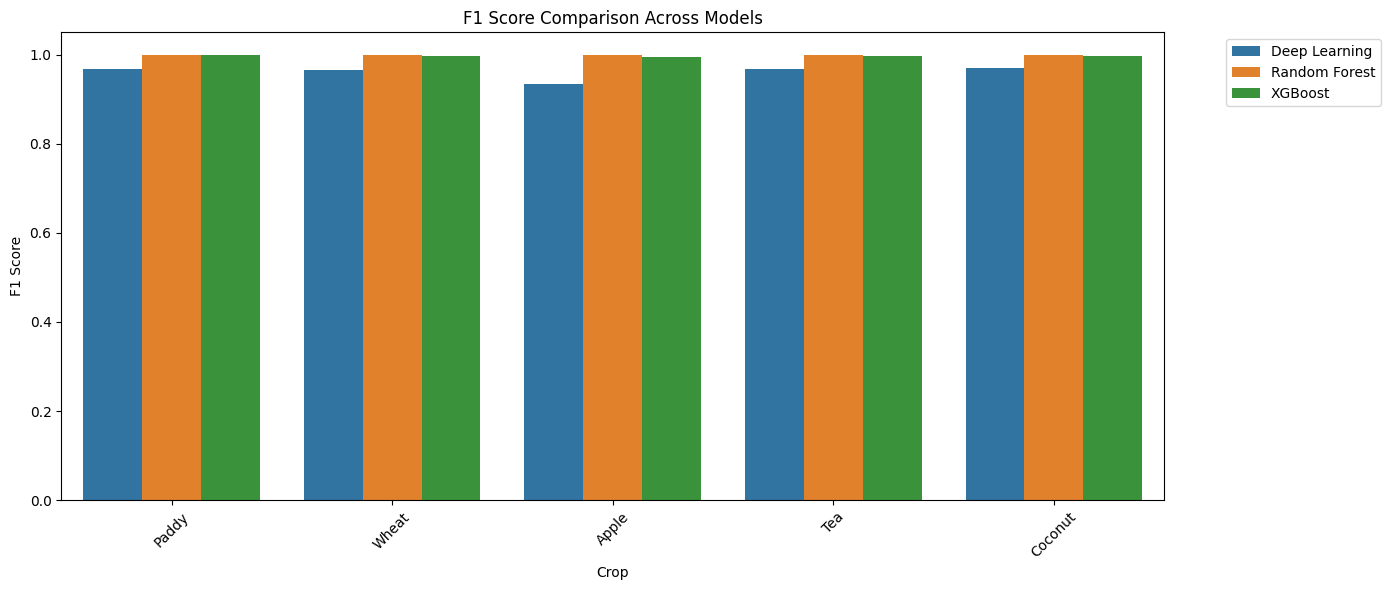

In [ ]:
# Model comparison plot
plt.figure(figsize=(14, 6))
sns.barplot(x='Crop', y='F1', hue='Model', data=all_metrics)
plt.title('F1 Score Comparison Across Models')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


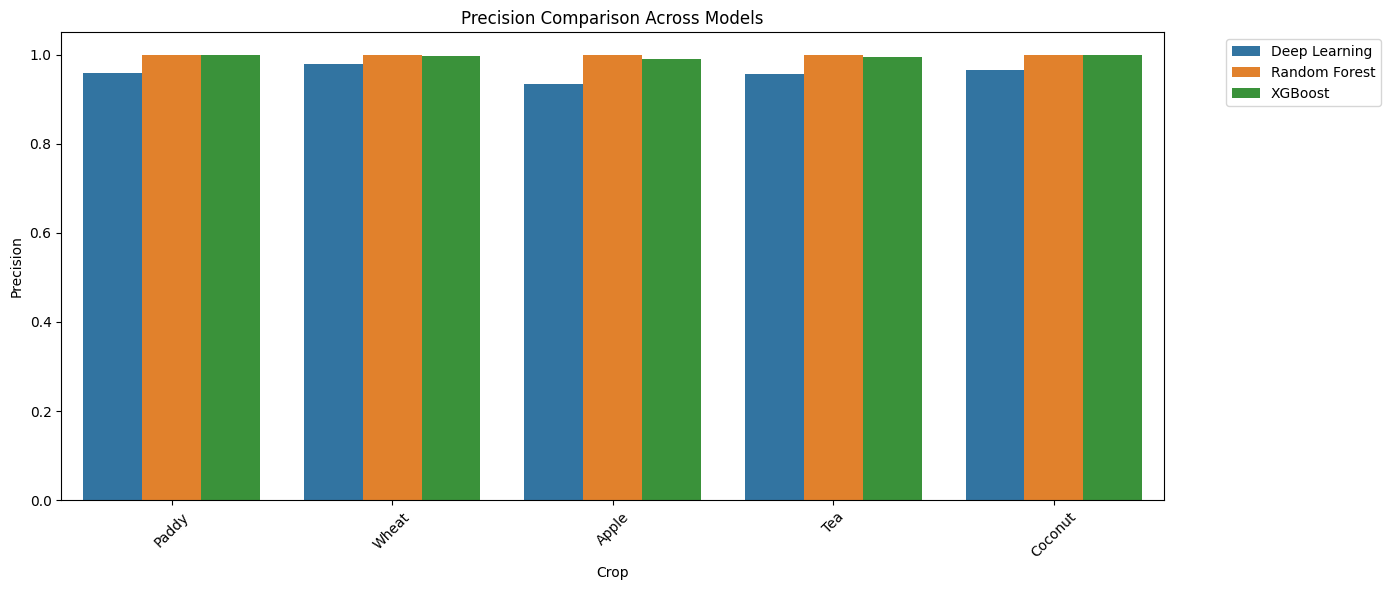

In [ ]:
# Model comparison plot
plt.figure(figsize=(14, 6))
# Corrected column name for precision and updated title
sns.barplot(x='Crop', y='Precision', hue='Model', data=all_metrics)
plt.title('Precision Comparison Across Models') # Updated title
plt.ylabel('Precision') # Updated y-axis label
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
"""## 6. Deployment Preparation"""

# Function to make predictions (example)
def predict_crop_suitability(features):
    """
    features: Dictionary containing:
        - NDVI
        - Annual_Rainfall
        - Temperature
        - pH_0_5
        - Carbon
        - State (encoded)
        - Season (encoded)
    """
    # Convert to DataFrame
    input_df = pd.DataFrame([features])

    # Add engineered features
    input_df['State_Rainfall_Deviation'] = input_df['Annual_Rainfall'] - state_rainfall_avg[input_df['State'].iloc[0]]
    input_df['State_Temp_Deviation'] = input_df['Temperature'] - state_temp_avg[input_df['State'].iloc[0]]
    input_df['Rainfall_Temp_Interaction'] = input_df['Annual_Rainfall'] * input_df['Temperature']
    input_df['NDVI_pH_Interaction'] = input_df['NDVI'] * input_df['pH_0_5']

    # Scale features
    scaled_features = scaler.transform(input_df)

    # Make predictions with DL model
    probabilities = model.predict(scaled_features)
    predictions = (probabilities > 0.5).astype(int)

    # Format results
    results = {}
    for i, crop in enumerate(selected_crops):
        results[crop] = {
            'suitable': bool(predictions[0, i]),
            'probability': float(probabilities[0, i])
        }

    return results

# Example prediction
example_features = {
    'NDVI': 0.67,
    'Annual_Rainfall': 2000,
    'Temperature': 27,
    'pH_0_5': 5.7,
    'Carbon': 500,
    'State': 5,  # Encoded state
    'Season': 1   # Encoded season
}

print("\nExample prediction:")
print(predict_crop_suitability(example_features))



Example prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
{'Paddy': {'suitable': True, 'probability': 0.9895876049995422}, 'Wheat': {'suitable': False, 'probability': 8.245297976827715e-06}, 'Apple': {'suitable': False, 'probability': 4.784416523762047e-05}, 'Tea': {'suitable': True, 'probability': 0.9951721429824829}, 'Coconut': {'suitable': True, 'probability': 0.9757758378982544}}


In [ ]:
"""## 6. Deployment Preparation"""

# Function to make predictions (example)
def predict_crop_suitability(features):
    """
    features: Dictionary containing:
        - NDVI
        - Annual_Rainfall
        - Temperature
        - pH_0_5
        - Carbon
        - State (encoded)
        - Season (encoded)
    """
    # Convert to DataFrame
    input_df = pd.DataFrame([features])

    # Add engineered features
    input_df['State_Rainfall_Deviation'] = input_df['Annual_Rainfall'] - state_rainfall_avg[input_df['State'].iloc[0]]
    input_df['State_Temp_Deviation'] = input_df['Temperature'] - state_temp_avg[input_df['State'].iloc[0]]
    input_df['Rainfall_Temp_Interaction'] = input_df['Annual_Rainfall'] * input_df['Temperature']
    input_df['NDVI_pH_Interaction'] = input_df['NDVI'] * input_df['pH_0_5']

    # Scale features
    scaled_features = scaler.transform(input_df)

    # Make predictions with DL model
    probabilities = model.predict(scaled_features)
    predictions = (probabilities > 0.5).astype(int)

    # Format results
    results = {}
    for i, crop in enumerate(selected_crops):
        results[crop] = {
            'suitable': bool(predictions[0, i]),
            'probability': float(probabilities[0, i])
        }

    return results

# Example prediction
example_features = {
    'NDVI': 0.67,
    'Annual_Rainfall': 1200,
    'Temperature': 15,
    'pH_0_5': 5.7,
    'Carbon': 300,
    'State': 5,  # Encoded state
    'Season': 1   # Encoded season
}

print("\nExample prediction:")
print(predict_crop_suitability(example_features))



Example prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
{'Paddy': {'suitable': False, 'probability': 0.01034691371023655}, 'Wheat': {'suitable': False, 'probability': 0.004626800771802664}, 'Apple': {'suitable': True, 'probability': 0.9508150219917297}, 'Tea': {'suitable': False, 'probability': 0.34157755970954895}, 'Coconut': {'suitable': False, 'probability': 0.0083296038210392}}


In [ ]:
df.head()

,Sample_ID,State,Season,Year,NDVI,Seasonal_Rainfall,Annual_Rainfall,Temperature,pH_0_5,Carbon,Texture,Paddy,Wheat,Apple,Tea,Coconut,State_Rainfall_Deviation,State_Temp_Deviation,Rainfall_Temp_Interaction,NDVI_pH_Interaction
0,b2536686-660b-4334-a039-1265f84376ea,6,1,2019,0.276150,410.340926,1781.260188,9.247273,5.6,512,7,0,0,0,0,0,632.996768,-8.006294,16471.798754,1.546440
1,36db9cc0-2f0b-4c51-bba9-e98cce5129b4,6,1,2019,-0.041020,134.413062,686.800254,1.059756,6.5,415,7,0,0,0,0,0,-461.463166,-16.193811,727.840757,-0.266630
2,a5169acb-4e5c-4eb7-8639-4655a9c2d0a5,6,1,2019,0.524933,166.432536,1435.953772,30.483208,6.2,389,4,1,0,0,0,1,287.690352,13.229640,43772.476857,3.254587
3,2d876a81-c8b6-4bc6-a08e-037636bed8fa,6,1,2019,0.545867,440.670034,2033.148385,13.110909,6.0,477,7,0,0,0,0,0,884.884965,-4.142658,26656.423648,3.275200
4,29710e28-de4b-434a-8b8c-11bcb0f1ebfc,6,1,2019,0.529517,191.456485,1900.826151,32.518302,6.1,384,7,1,0,0,0,1,752.562731,15.264735,61811.638610,3.230052


In [ ]:
import joblib
import numpy as np
import pandas as pd

# Load models
rf_model = joblib.load('crop_suitability_rf_model.pkl')
xgb_model = joblib.load('crop_suitability_xgb_model.pkl')

# Load your scaler
scaler = joblib.load('feature_scaler.pkl')

In [ ]:
# Example new observation
new_sample = {
    'NDVI': 0.67,
    'Annual_Rainfall': 1200,
    'Temperature': 15,
    'pH_0_5': 5.7,
    'Carbon': 300,
    'State': 5,  # Encoded value
    'Season': 1   # Encoded value
}

# Convert to DataFrame and scale
new_df = pd.DataFrame([new_sample])

# Add engineered features - This block was missing in the original code
# Assuming state_rainfall_avg and state_temp_avg are available from previous cells.
new_df['State_Rainfall_Deviation'] = new_df.apply(lambda x: x['Annual_Rainfall'] - state_rainfall_avg[x['State']], axis=1)
new_df['State_Temp_Deviation'] = new_df.apply(lambda x: x['Temperature'] - state_temp_avg[x['State']], axis=1)
new_df['Rainfall_Temp_Interaction'] = new_df['Annual_Rainfall'] * new_df['Temperature']
new_df['NDVI_pH_Interaction'] = new_df['NDVI'] * new_df['pH_0_5']

# Select only the features that were used for training - This is also needed
# Assuming 'features' list is available from previous cells
new_df_processed = new_df[features]


# Scale features
new_scaled = scaler.transform(new_df_processed) # Scale the DataFrame with engineered features

# RF Prediction
rf_single_pred = rf_model.predict(new_scaled)
rf_single_prob = np.array([est.predict_proba(new_scaled)[:, 1] for est in rf_model.estimators_]).T[0]

# XGB Prediction
xgb_single_pred = xgb_model.predict(new_scaled)
xgb_single_prob = np.array([est.predict_proba(new_scaled)[:, 1] for est in xgb_model.estimators_]).T[0]

# Format results
results = []
for i, crop in enumerate(selected_crops):
    results.append({
        'Crop': crop,
        'RF_Prediction': rf_single_pred[0][i],
        'RF_Probability': rf_single_prob[i],
        'XGB_Prediction': xgb_single_pred[0][i],
        'XGB_Probability': xgb_single_prob[i]
    })

results_df = pd.DataFrame(results)
print(results_df)

      Crop  RF_Prediction  RF_Probability  XGB_Prediction  XGB_Probability
0    Paddy              0            0.00               0         0.000015
1    Wheat              0            0.01               0         0.000051
2    Apple              1            0.55               1         0.956496
3      Tea              1            0.59               0         0.173146
4  Coconut              0            0.01               0         0.000195


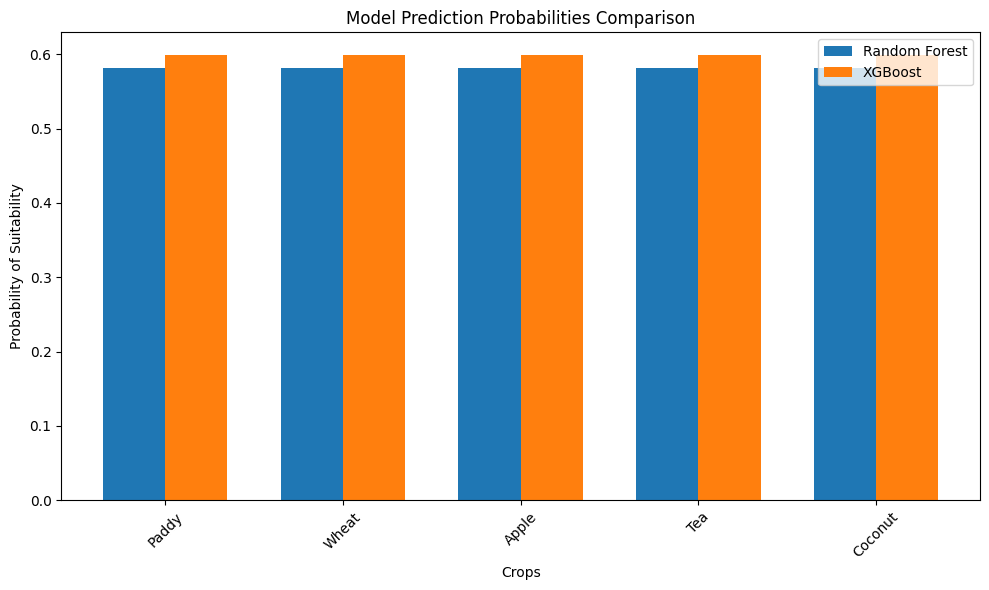

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
crops = selected_crops
rf_probs = rf_probs.mean(axis=0)  # Average across estimators
xgb_probs = xgb_probs.mean(axis=0)

# Plot
plt.figure(figsize=(10, 6))
x = np.arange(len(crops))
width = 0.35

plt.bar(x - width/2, rf_probs, width, label='Random Forest')
plt.bar(x + width/2, xgb_probs, width, label='XGBoost')

plt.xlabel('Crops')
plt.ylabel('Probability of Suitability')
plt.title('Model Prediction Probabilities Comparison')
plt.xticks(x, crops, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()